## ThinkDSP

This notebook contains solutions to exercises in Chapter 8: Filtering and Convolution

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [ ]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Exercise 1

In this chapter I claimed that the Fourier transform of a Gaussian
curve is also a Gaussian curve.  For discrete Fourier transforms,
this relationship is approximately true.

Try it out for a few examples.  What happens to the Fourier transform
as you vary `std`?

### Solution

I'll start with a Gaussian similar to the example in the book.

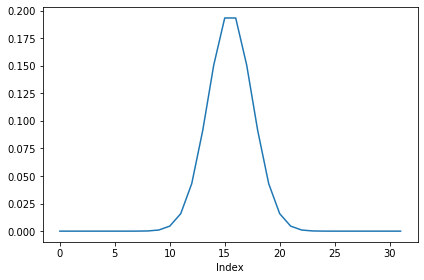

In [3]:
import scipy.signal

gaussian = scipy.signal.gaussian(M=32, std=2)
gaussian /= sum(gaussian)
plt.plot(gaussian)
decorate(xlabel='Index')

Here's what the FFT looks like:

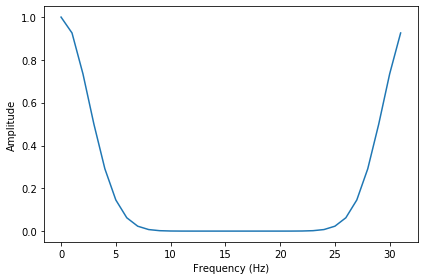

In [4]:
fft_gaussian = np.fft.fft(gaussian)
plt.plot(abs(fft_gaussian))
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

If we roll the negative frequencies around to the left, we can see more clearly that it is Gaussian, at least approximately.

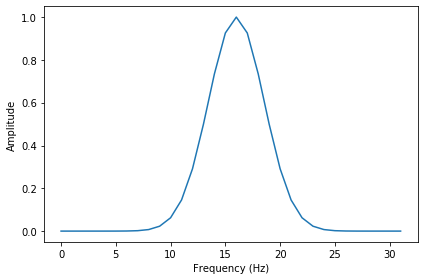

In [5]:
N = len(gaussian)
fft_rolled = np.roll(fft_gaussian, N//2)
plt.plot(abs(fft_rolled))
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

This function plots the Gaussian window and its FFT side-by-side.

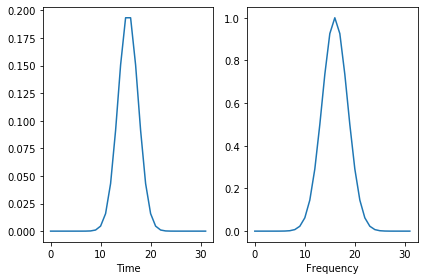

In [6]:
def plot_gaussian(std):
    M = 32
    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    
    plt.subplot(1, 2, 1)
    plt.plot(gaussian)
    decorate(xlabel='Time')

    fft_gaussian = np.fft.fft(gaussian)
    fft_rolled = np.roll(fft_gaussian, M//2)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.abs(fft_rolled))
    decorate(xlabel='Frequency')
    plt.show()

plot_gaussian(2)

Now we can make an interaction that shows what happens as `std` varies.

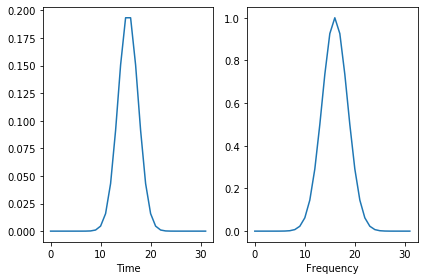

In [7]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.FloatSlider(min=0.1, max=10, value=2)
interact(plot_gaussian, std=slider);

As `std` increases, the Gaussian gets wider and its FFT gets narrower.

In terms of continuous mathematics, if

$f(x) = e^{-a x^2}$

which is a Gaussian with mean 0 and standard deviation $1/a$, its Fourier transform is

$F(k) = \sqrt{\frac{\pi}{a}} e^{-\pi^2 k^2/a}$

which is a Gaussian with standard deviation $a / \pi^2$.  So there is an inverse relationship between the standard deviations of $f$ and $F$.

For the proof, see http://mathworld.wolfram.com/FourierTransformGaussian.html

## Exercise 2

If you did the exercises in Chapter 3, you saw the effect of the Hamming window, and some of the other windows provided by NumPy, on spectral leakage.  We can get some insight into the effect of these windows by looking at their DFTs.

In addition to the Gaussian window we used in this window, create a Hamming window with the same size.  Zero pad the windows and plot their DFTs.  Which window acts as a better low-pass filter?  You might find it useful to plot the DFTs on a log-$y$ scale.

Experiment with a few different windows and a few different sizes.

### Solution

Following the examples from the chapter, I'll create a 1-second wave sampled at 44.1 kHz.

In [8]:
from thinkdsp import SquareSignal

signal = SquareSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)

And I'll create a few windows.  I chose the standard deviation of the Gaussian window to make it similar to the others.

In [9]:
M = 15
std = 2.5

gaussian = scipy.signal.gaussian(M=M, std=std)   
bartlett = np.bartlett(M)
blackman = np.blackman(M)
hamming = np.hamming(M)
hanning = np.hanning(M)

windows = [blackman, gaussian, hanning, hamming]
names = ['blackman', 'gaussian', 'hanning', 'hamming']

for window in windows:
    window /= sum(window)

Let's see what the windows look like.

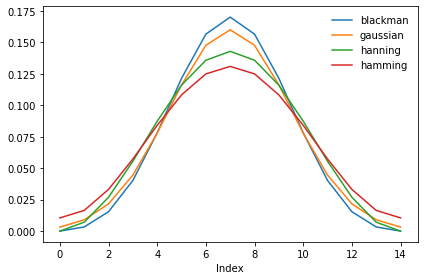

In [10]:
for window, name in zip(windows, names):
    plt.plot(window, label=name)

decorate(xlabel='Index')

They are pretty similar.  Let's see what their DFTs look like:

In [11]:
def zero_pad(array, n):
    """Extends an array with zeros.

    array: NumPy array
    n: length of result

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

In [12]:
def plot_window_dfts(windows, names):
    """
    """
    for window, name in zip(windows, names):
        padded =  zero_pad(window, len(wave))
        dft_window = np.fft.rfft(padded)
        plt.plot(abs(dft_window), label=name)

Also pretty similar, but it looks like Hamming drops off the fastest, Blackman the slowest, and Hanning has the most visible sidelobes.

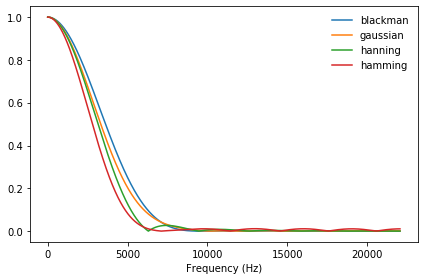

In [13]:
plot_window_dfts(windows, names)
decorate(xlabel='Frequency (Hz)')

Here's the same plot on a log-y scale.

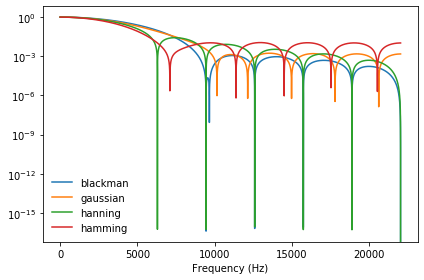

In [14]:
plot_window_dfts(windows, names)
decorate(xlabel='Frequency (Hz)', yscale='log')

On a log scale we can see that the Hamming and Hanning drop off faster than the other two at first.  And the Hamming and Gaussian windows seem to have the most persistent sidelobes.  The Hanning window might have the best combination of fast drop off and minimal sidelobes.